# ***CONNECTING TO GOOGLE DRIVE***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***LIBRARIES***

In [ ]:
import torch
import os
import torch.nn as nn
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import torch.nn.functional as Func
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

#torch.manual_seed(123)
np.random.seed(123)

# ***MODEL***

In [ ]:
# Define the ABU activation function for the SABR PDE
class SinSoftplusActivation(nn.Module):
    def forward(self, input):
        new_act_f = 0.005*torch.sin(input) + 1*torch.nn.functional.softplus(input) + 0.00*torch.nn.functional.tanh(input) + 0.00*torch.nn.functional.gelu(input)
        return new_act_f

In [ ]:
class Alternative_FCN(nn.Module):
    def __init__(self):
        super(Alternative_FCN, self).__init__()
        self.bn1 = nn.BatchNorm1d(3)
        self.fc1 = nn.Linear(3, 200)
        self.act1 = SinSoftplusActivation()
        self.bn2 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 200)
        self.act2 = SinSoftplusActivation()
        self.bn3 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, 200)
        self.act3 = SinSoftplusActivation()
        self.bn4 = nn.BatchNorm1d(200)
        self.fc4 = nn.Linear(200, 200)
        self.act4 = SinSoftplusActivation()
        self.bn5 = nn.BatchNorm1d(200)
        self.fc5 = nn.Linear(200, 200)
        self.act5 = SinSoftplusActivation()
        self.bn6 = nn.BatchNorm1d(200)
        self.fc6 = nn.Linear(200, 1)


    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        x = self.fc6(x)
        return x

# ***RANDOM DATASET GENERATION FOR PDE AND OTHER CONDITIONS***

Total points: 2190
Interior: 365 points (S∈[0.2, 149.8])
S=0 boundary: 365 points (σ∈[0.0, 0.5])
σ=0 boundary: 365 points (S∈[0.0, 149.9])


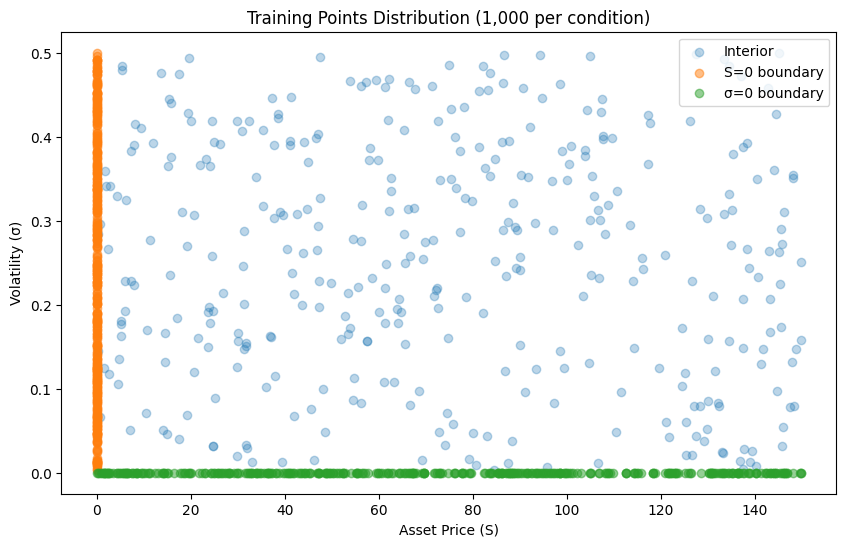

In [ ]:
def generate_points_per_condition(N=1000, S_min=0.0, S_max=150.0,
                                sigma_min=0.0, sigma_max=0.5, t=1.0):
    """
    Generates 1,000 random points for each:
    - Interior domain
    - S=0 boundary
    - S=S_max boundary
    - σ=0 boundary
    - σ=σ_max boundary
    - Initial condition (t=T)
    """
    # --- Interior points (S, σ, t all random) ---
    S_int = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma_int = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_int = torch.rand(N, 1) * t
    interior = torch.cat([S_int, sigma_int, t_int], dim=1)

    # --- Boundary: S=0 (σ and t random) ---
    S0 = torch.zeros(N, 1)
    sigma_S0 = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_S0 = torch.rand(N, 1) * t
    bd_S0 = torch.cat([S0, sigma_S0, t_S0], dim=1)

    # --- Boundary: S=S_max (σ and t random) ---
    Smax = torch.ones(N, 1) * S_max
    sigma_Smax = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_Smax = torch.rand(N, 1) * t
    bd_Smax = torch.cat([Smax, sigma_Smax, t_Smax], dim=1)

    # --- Boundary: σ=0 (S and t random) ---
    S_sigma0 = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma0 = torch.zeros(N, 1)
    t_sigma0 = torch.rand(N, 1) * t
    bd_sigma0 = torch.cat([S_sigma0, sigma0, t_sigma0], dim=1)

    # --- Boundary: σ=σ_max (S and t random) ---
    S_sigmamax = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigmamax = torch.ones(N, 1) * sigma_max
    t_sigmamax = torch.rand(N, 1) * t
    bd_sigmamax = torch.cat([S_sigmamax, sigmamax, t_sigmamax], dim=1)

    # --- Initial condition: t=T (S and σ random) ---
    S_initial = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma_initial = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_initial = torch.zeros(N, 1)
    initial = torch.cat([S_initial, sigma_initial, t_initial], dim=1)

    # Combine all (total points = 6*N)
    all_points = torch.cat([
        interior, bd_S0, bd_Smax, bd_sigma0, bd_sigmamax, initial
    ], dim=0).requires_grad_(True)

    return {
        'interior': interior,
        'bd_S0': bd_S0,
        'bd_Smax': bd_Smax,
        'bd_sigma0': bd_sigma0,
        'bd_sigmamax': bd_sigmamax,
        'initial': initial,
        'all': all_points
    }

# Generate 1,000 points per condition
data = generate_points_per_condition(N=365)

# Verify
print(f"Total points: {len(data['all'])}")
print(f"Interior: {len(data['interior'])} points (S∈[{data['interior'][:,0].min():.1f}, {data['interior'][:,0].max():.1f}])")
print(f"S=0 boundary: {len(data['bd_S0'])} points (σ∈[{data['bd_S0'][:,1].min():.1f}, {data['bd_S0'][:,1].max():.1f}])")
print(f"σ=0 boundary: {len(data['bd_sigma0'])} points (S∈[{data['bd_sigma0'][:,0].min():.1f}, {data['bd_sigma0'][:,0].max():.1f}])")

# Plot S-σ distribution
plt.figure(figsize=(10, 6))
plt.scatter(data['interior'][:,0], data['interior'][:,1], label='Interior', alpha=0.3)
plt.scatter(data['bd_S0'][:,0], data['bd_S0'][:,1], label='S=0 boundary', alpha=0.5)
plt.scatter(data['bd_sigma0'][:,0], data['bd_sigma0'][:,1], label='σ=0 boundary', alpha=0.5)
plt.xlabel("Asset Price (S)"), plt.ylabel("Volatility (σ)")
plt.title("Training Points Distribution (1,000 per condition)")
plt.legend()
plt.show()

# ***PDE AND PINN CONDITIONS***

In [ ]:
# Define a function to compute the partial derivatives needed for the SABR PDE
def compute_derivatives(model, S, sigma, t):
    inputs = torch.cat([S, sigma, t], dim=1)
    # Compute C (option price)
    C = model(inputs)

    # Compute partial derivatives using autograd
    C_S = torch.autograd.grad(C, S, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_sigma = torch.autograd.grad(C, sigma, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_t = torch.autograd.grad(C, t, grad_outputs=torch.ones_like(C), create_graph=True)[0]

    C_SS = torch.autograd.grad(C_S, S, grad_outputs=torch.ones_like(C_S), create_graph=True)[0]
    C_sigmasigma = torch.autograd.grad(C_sigma, sigma, grad_outputs=torch.ones_like(C_sigma), create_graph=True)[0]
    C_Ssigma = torch.autograd.grad(C_S, sigma, grad_outputs=torch.ones_like(C_S), create_graph=True)[0]

    return C, C_S, C_sigma, C_t, C_SS, C_Ssigma, C_sigmasigma

    # Define the SABR PDE
def sabr_pde(model, S, sigma, t, beta, nu, rho, r):
    C, C_S, C_sigma, C_t, C_SS, C_Ssigma, C_sigmasigma = compute_derivatives(model, S, sigma, t)

    # Compute the terms of the SABR PDE
    term1 = C_t
    term2 = 0.5 * sigma**2 * S**(2*beta) * C_SS
    term3 = rho * nu * (sigma**2) * S**beta * C_Ssigma
    term4 = 0.5 * nu**2 * (sigma**2) * C_sigmasigma
    term5 = r * S * C_S
    term6 = -r * C

    # SABR PDE that equal to zero
    residual = term1 + term2 + term3 + term4 + term5 + term6
    return residual

def IC_european_call(S, K):
    val = torch.maximum(S - K, torch.tensor(0.0))  # Eleman eleman maksimum değerleri al
    return val.view(-1, 1).requires_grad_(True)

# Define boundary conditions
def Smin_conditions(model, inputs_S_min):
    # Boundary condition for S = S_min
    boundary_S_min = model(inputs_S_min)  # V(t, F_min, alpha) = 0
    boundary_S_min = torch.mean(boundary_S_min**2)

    return boundary_S_min

# Define boundary conditions
def Smax_conditions2(model,  inputs_S_max):
    # Boundary condition for S = S_max (Neumann condition ∂V/∂F = 1)
    fSmax = inputs_S_max[:, 0].requires_grad_(True).reshape(-1, 1)
    V_S_max = model(inputs_S_max)
    V_S_max_dx = torch.autograd.grad(V_S_max, inputs_S_max, torch.ones_like(V_S_max), create_graph=True)[0]
    dVdS = V_S_max_dx[:, 0].reshape(-1, 1)
    boundary_S_max = dVdS - 1  # ∂V/∂F = 1
    boundary_S_max = torch.mean(boundary_S_max**2)
    return boundary_S_max

    # Define boundary conditions
def Smax_conditions(model,  inputs_S_max):
    # Boundary condition for S = S_max (Neumann condition ∂V/∂F = 1)
    fSmax = inputs_S_max[:, 0].requires_grad_(True).reshape(-1, 1)
    V_S_max = model(inputs_S_max)
    V_S_max_dx = torch.autograd.grad(V_S_max, inputs_S_max, torch.ones_like(V_S_max), create_graph=True)[0]
    V_S_max_d2x = torch.autograd.grad(V_S_max_dx, inputs_S_max, torch.ones_like(V_S_max_dx), create_graph=True)[0]
    dSmaxd2x = V_S_max_d2x[:, 0].reshape(-1, 1)
    boundary_S_max = torch.mean(dSmaxd2x**2)
    return boundary_S_max

# Define boundary conditions
def v0_conditions(model, inputs_v_min, K, r):
    # Boundary condition for alpha = 0 (∂V/∂t = 0)
    Vmin_S = inputs_v_min[:, 0].reshape(-1, 1)
    Vmin_t = inputs_v_min[:, 2].reshape(-1, 1)
    V_v_min = model(inputs_v_min)
    V_v_min_dt = torch.autograd.grad(V_v_min, inputs_v_min, torch.ones_like(V_v_min), create_graph=True)[0]
    dVmindt = V_v_min_dt[:, 2].reshape(-1, 1)
    #boundary_alpha_min = V_alpha_min_dt  # ∂V/∂t = 0
    boundary_v_min = V_v_min - torch.maximum(Vmin_S - K*torch.exp(-r*Vmin_t), torch.tensor(0.0))
    boundary_v_min = torch.mean(boundary_v_min**2)

    return boundary_v_min

# Define boundary conditions
def Vmax_conditions(model, inputs_v_max, beta):
    Vmax_S = inputs_v_max[:, 0].reshape(-1, 1)
    Vmax = inputs_v_max[:, 1].reshape(-1, 1)
    Vmax_t = inputs_v_max[:, 2].reshape(-1, 1)

    # Boundary condition for alpha = alpha_max
    V_v_max = model(inputs_v_max)

    V_v_max_dt = torch.autograd.grad(V_v_max, inputs_v_max, torch.ones_like(V_v_max), create_graph=True)[0]
    dVmaxdt = V_v_max_dt[:, 2].reshape(-1, 1)

    V_v_max_dx = torch.autograd.grad(V_v_max, inputs_v_max,  torch.ones_like(V_v_max), create_graph=True)[0]
    dVmaxdx = V_v_max_dx[:, 0].reshape(-1, 1)

    V_v_max_d2x = torch.autograd.grad(V_v_max_dx, inputs_v_max, torch.ones_like(V_v_max_dx), create_graph=True)[0]
    dVmaxd2x = V_v_max_d2x[:, 0].reshape(-1, 1)

    boundary_v_max = dVmaxdt + 0.5 * Vmax**2 * (Vmax_S**(2*beta)) * dVmaxd2x  # Combined condition
    boundary_v_max = torch.mean(boundary_v_max**2)

    return boundary_v_max


# ***ANALYTICAL BS - MANTO CARLO - SABR PATH GENERATION***

In [ ]:
# ANALYTICAL BS OPTION PRICE

def black_scholes_option_price(S, K, T, r, sigma, option_type='call'):

    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T+0.00000001))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        # Calculate the price of a European call option
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        # Calculate the price of a European put option
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return option_price


# SABR PATH SIMULATION

def simulate_sabr_path(beta, nu, rho,
                       F0, sigma0, strike_price,
                       T, N, r, plot=True):
    np.random.seed(123)
    dt = T / N
    dW1 = np.random.normal(0, np.sqrt(dt), N)
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), N)

    if plot:
        plt.plot(dW1, label='dW1')
        plt.plot(dW2, label='dW2')
        plt.title("Brownian Motions")
        plt.xlabel("Steps (N)")
        plt.ylabel("W_1 and W_2")
        plt.legend()
        plt.show()

    F = np.zeros(N)
    sigma = np.zeros(N)
    F[0] = F0
    sigma[0] = sigma0

    for t in range(1, N):
        #discount_F = F0 * np.exp(r * (t-1))
        F[t] = F[t-1] + sigma[t-1] * (F[t-1])**beta * dW1[t-1]
        sigma[t] = sigma[t-1] + nu * sigma[t-1] * dW2[t-1]

    return F, sigma


def sabr_european_call_mc(S0_array, sigma0_array, T_array, K, r,
                          beta, nu, rho, N, M, confidence=0.95):

    S0_array = np.asarray(S0_array).flatten()
    sigma0_array = np.asarray(sigma0_array).flatten()
    T_array = np.asarray(T_array).flatten()

    n_samples = len(S0_array)
    prices = np.zeros(n_samples)
    conf_intervals = []

    z_score = norm.ppf(1 - (1 - confidence) / 2)

    for i in range(n_samples):
        S0 = S0_array[i]
        alpha0 = sigma0_array[i]
        T = T_array[i]
        dt = T / N
        sqrt_dt = np.sqrt(dt)

        # Initialize arrays
        S = np.zeros((M, N+1))
        alpha = np.zeros((M, N+1))
        S[:, 0] = S0
        alpha[:, 0] = alpha0

        for t in range(N):
            z1 = np.random.randn(M)
            z2 = np.random.randn(M)
            dW1 = z1
            dW2 = rho * z1 + np.sqrt(1 - rho**2) * z2

            alpha[:, t+1] = alpha[:, t] + nu * alpha[:, t] * dW2 * sqrt_dt
            S[:, t] = np.maximum(S[:, t], 1e-12)
            sigma_S = alpha[:, t] * (S[:, t]**(beta))
            mu_S = r * S[:, t]
            S[:, t+1] = S[:, t] + mu_S * dt + sigma_S * dW1 * sqrt_dt
            #S[:, t+1] = S[:, t]  + sigma_S * dW1 * sqrt_dt

        # Call option payoff
        payoffs = np.maximum(S[:, -1] - K, 0)
        discounted = np.exp(-r * T) * payoffs

        mean_price = np.mean(discounted)
        prices[i] = mean_price

    return prices



# ***TRAINING***

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  current = float(metrics)


Iteration 0, Loss: 14725718.0
Loss-1 (IC): 2.2487378714686201e-07, Loss-2 (pde): 5.7109624322038144e-05 , Loss-5 (bd): 14725718.0
LR: 2.00e-04
Iteration 100, Loss: 417834.8125
Loss-1 (IC): 2.117331803219713e-07, Loss-2 (pde): 0.6570472121238708 , Loss-5 (bd): 417834.15625
LR: 2.00e-04
Iteration 200, Loss: 6577.517578125
Loss-1 (IC): 2.371957776858835e-07, Loss-2 (pde): 2.6406445503234863 , Loss-5 (bd): 6574.876953125
LR: 2.00e-04
Iteration 300, Loss: 5141.14697265625
Loss-1 (IC): 2.395148328560026e-07, Loss-2 (pde): 4.284910202026367 , Loss-5 (bd): 5136.8623046875
LR: 2.00e-04
Iteration 400, Loss: 3654.83837890625
Loss-1 (IC): 2.387380106938508e-07, Loss-2 (pde): 5.626290798187256 , Loss-5 (bd): 3649.212158203125
LR: 2.00e-04
Iteration 500, Loss: 3126.477783203125
Loss-1 (IC): 2.324022858601893e-07, Loss-2 (pde): 6.792487621307373 , Loss-5 (bd): 3119.685302734375
LR: 2.00e-04
Iteration 600, Loss: 2494.26171875
Loss-1 (IC): 2.219021411065114e-07, Loss-2 (pde): 8.364801406860352 , Loss-5

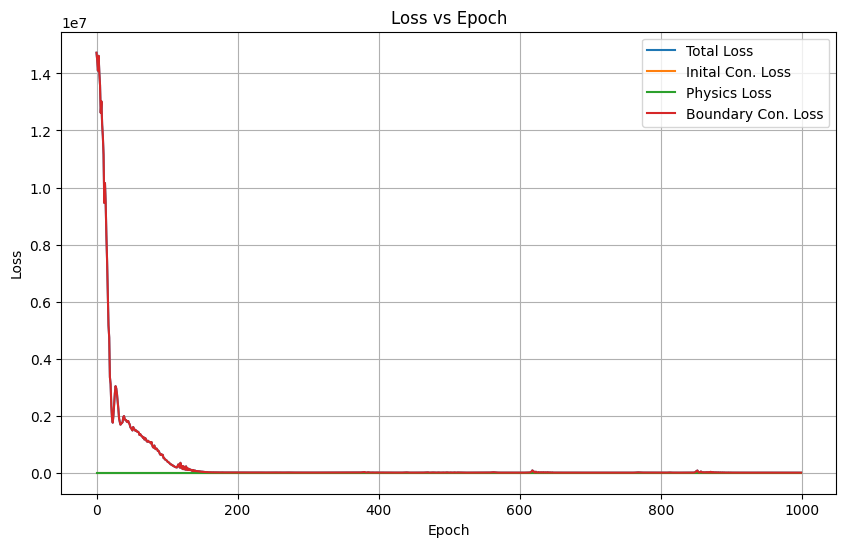

In [ ]:
# SABR parameters
beta = 1
nu = 0.
rho = -0.2
strike_price = 50
T = 1.0  # Vade süresi
N = 365  # Zaman adımı sayısı
F0 = 100  # Forward başlangıç fiyatı
sigma0 = 0.25  # Volatilite başlangıç değeri
r=0.05

F, sigma = simulate_sabr_path(beta, nu, rho, F0, sigma0, strike_price, T, N, r, plot=False)

# Veriyi torch tensöre dönüştür
F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1)
sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1)

# min max değerler
F_min, F_max = torch.min(F_torch).item(), torch.max(F_torch).item()
v_min, v_max = torch.min(sigma_torch).item(), torch.max(sigma_torch).item()

lambda1, lambda2 = 1, 1

model = Alternative_FCN()
optimizer = torch.optim.Adam(model.parameters(),lr=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=200,
    min_lr=2e-5)

best_loss = float('inf')  # En düşük lossu takip etmek için
save_path = 'best_model.pth'

totallosses=[]
Lic_list = []
Lpde_list = []
Lbd_list = []
Lbd_Smax_list = []
Lbd_S0_list = []
Lbd_Vmax_list = []
Lbd_V0_list = []

# Compute model

for i in range(1000):
    data = generate_points_per_condition(N=1000, S_min=0.0, S_max=1.2*F_max,
                                    sigma_min=0.0, sigma_max=1.1*v_max, t=1.0)

    t0 = data['initial'].clone().detach().requires_grad_(True)
    V0 = data['bd_sigma0'].clone().detach().requires_grad_(True)
    S0 = data['bd_S0'].clone().detach().requires_grad_(True)
    Smax = data['bd_Smax'].clone().detach().requires_grad_(True)
    vmax = data['bd_sigmamax'].clone().detach().requires_grad_(True)
    inputs = data['interior'].clone().detach().requires_grad_(True)
    inputs_all = data['all'].clone().detach().requires_grad_(True)


    C0 = model(t0)
    loss1 = (torch.squeeze(C0) - IC_european_call(t0[:,0].requires_grad_(True).reshape(-1, 1), strike_price))**2
    Lic = lambda1 * loss1.mean()

    # Compute the PDE residual as the loss
    residual = sabr_pde(model, inputs[:,0].requires_grad_(True).reshape(-1, 1), inputs[:,1].requires_grad_(True).reshape(-1, 1), inputs[:,2].requires_grad_(True).reshape(-1, 1), beta, nu, rho, r)
    Lpde = lambda2 * torch.mean(residual**2)

    bnd_S_min = Smin_conditions(model, S0)

    bnd_S_max = Smax_conditions(model, Smax)

    bnd_v_min = v0_conditions(model, V0, strike_price, r)

    bnd_v_max = Vmax_conditions(model, vmax, beta)

    Lbd = ( 10*bnd_S_max + 1000*bnd_v_max + 10000*bnd_v_min + 1*bnd_S_min )
    Lic2 = 0.00000000015*Lic
    Lpde2 = 1*Lpde
    loss = Lic2 + Lpde2 + Lbd


    loss.backward(retain_graph=True)
    optimizer.step()
    scheduler.step(loss)
    optimizer.zero_grad()

    totallosses.append(loss.item())
    Lic_list.append(Lic2.item())
    Lpde_list.append(Lpde2.item())
    Lbd_list.append(Lbd.item())
    Lbd_Smax_list.append(10*bnd_S_max.item())
    Lbd_S0_list.append(1*bnd_S_min.item())
    Lbd_Vmax_list.append(1000*bnd_v_max.item())
    Lbd_V0_list.append(1000*bnd_v_max.item())

    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")
        print(f"Loss-1 (IC): {Lic2.item()}, Loss-2 (pde): {Lpde2.item()} , Loss-5 (bd): {Lbd.item()}")
        current_lr = optimizer.param_groups[0]['lr']
        print(f'LR: {current_lr:.2e}')

        # En iyi model
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
            'iteration': i
            }, save_path)

print("best loss: ", best_loss )

checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"Model {checkpoint['iteration']} iterasyondan yüklendi, Loss: {checkpoint['loss']:.6f}")


# After training loop, plot the loss vs epoch graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(totallosses)), totallosses, label='Total Loss')
plt.plot(range(len(totallosses)), Lic_list, label='Inital Con. Loss')
plt.plot(range(len(totallosses)), Lpde_list, label='Physics Loss')
plt.plot(range(len(totallosses)), Lbd_list, label='Boundary Con. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.grid(True)
plt.legend()
plt.show()


#  ***Result on Syntetic Dataset by using SABR Path***


In [ ]:

loss_df = pd.DataFrame(columns=["Total", "ic", "bd", "phy","Smax", "S0", "Vmax", "V0"])

# Output directory to save the plots
output_dir = "/content/drive/MyDrive/Bitirme_real_dataset/new/euro/simulations"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# PINN, BS ve Monte Carlo değerlerini içeren DataFrame
loss_df = pd.DataFrame({
    "Total": totallosses,
    "ic": Lic_list,
    "bd": Lbd_list,
    "phy": Lpde_list,
    "Smax": Lbd_Smax_list,
    "S0": Lbd_S0_list,
    "Vmax": Lbd_Vmax_list,
    "V0": Lbd_V0_list
})

# Kaydedilecek Excel dosyasının yolu
excel_path = os.path.join(output_dir, "loss.xlsx")

# Excel dosyasına yaz
loss_df.to_excel(excel_path, index=False)

print(f"Sonuçlar başarıyla şuraya kaydedildi: {excel_path}")

Sonuçlar başarıyla şuraya kaydedildi: /content/drive/MyDrive/Bitirme_real_dataset/new/euro/simulations/loss.xlsx


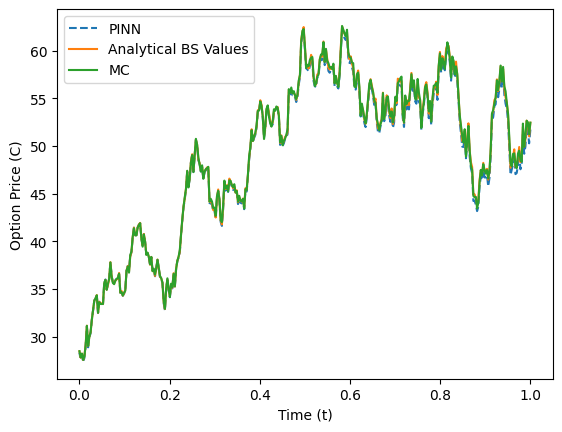

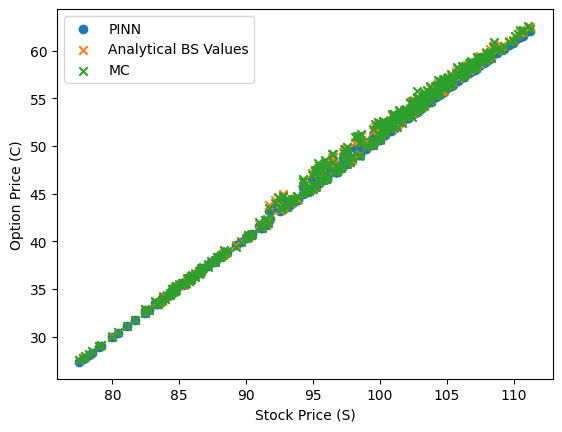

In [ ]:
beta =1
nu = 0.
rho = -0.2
strike_price = 50
T = 1.0  # Vade süresi
N = 365  # Zaman adımı sayısı
F0 = 100  # Forward başlangıç fiyatı
sigma0 = 0.25  # Volatilite başlangıç değeri
r=0.05

F, sigma = simulate_sabr_path(beta, nu, rho, F0, sigma0, strike_price, T, N, r, plot=False)

time_np = np.linspace(0, T, N)
time = np.flip(time_np).copy()

F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1)
sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1)
time_torch = torch.tensor(time, dtype=torch.float32, requires_grad=True).view(-1, 1)
inputs_sabr = torch.cat([F_torch, sigma_torch, time_torch], dim=1)

C = model(inputs_sabr) # PINN OPTION PRICES
C = C.detach().numpy()

bs_op_pr = black_scholes_option_price(F, strike_price, time, r, sigma) # ANALYTICAL BS OPTION PRICES

#prices = sabr_option_prices(F, sigma, time, strike_price, r, beta, rho, nu)  # MONTE CARLO OPTIONS PRİCES
mc = sabr_european_call_mc(F, sigma, time, strike_price, r, beta, nu=0., rho=-0.2, N=100, M=10000, confidence=0.95)


# Sonuçları çizdirme (PINN )
plt.plot(time, C, label="PINN", linestyle='dashed')
plt.plot(time, bs_op_pr, label="Analytical BS Values")
plt.plot(time, mc, label="MC")
plt.xlabel("Time (t)")
plt.ylabel("Option Price (C)")
plt.legend()
plt.show()

plt.scatter(F, C, label="PINN", marker='o')
plt.scatter(F, bs_op_pr, label="Analytical BS Values", marker="x")
plt.scatter(F, mc, label="MC", marker="x")
plt.xlabel("Stock Price (S)")
plt.ylabel("Option Price (C)")
plt.legend()
plt.show()


In [ ]:
# DataFrame to store the MSE and MAPE values for each sheet
prediction_df = pd.DataFrame(columns=["Prediction", "MC", "BS", "S", "Sigma", "t"])

# Output directory to save the plots
output_dir = "/content/drive/MyDrive/Bitirme_real_dataset/new/euro/simulations/0005sin-soft-2"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# PINN, BS ve Monte Carlo değerlerini içeren DataFrame
prediction_df = pd.DataFrame({
    "Prediction": C.flatten(),
    "MC": mc.flatten(),
    "BS": bs_op_pr.flatten(),
    "S": F.flatten(),
    "Sigma": sigma.flatten(),
    "t": time.flatten()
})

# Kaydedilecek Excel dosyasının yolu
excel_path = os.path.join(output_dir, "option_price_comparison_beta1_nu0-2.xlsx")

# Excel dosyasına yaz
prediction_df.to_excel(excel_path, index=False)

print(f"Sonuçlar başarıyla şuraya kaydedildi: {excel_path}")

Sonuçlar başarıyla şuraya kaydedildi: /content/drive/MyDrive/Bitirme_real_dataset/new/euro/simulations/0005sin-soft-2/option_price_comparison_beta1_nu0-2.xlsx


# ***RESULTS ON RANDOM DATASET***

In [ ]:
data = generate_points_per_condition(N=1000, S_min=0.0, S_max=F_max,
                                    sigma_min=0.0, sigma_max=v_max, t=1.0)

input_all =  data['interior']

C = model(input_all)
C = C.detach().numpy()

bs_op_pr = black_scholes_option_price(input_all[:,0].detach().numpy(), strike_price, input_all[:,2].detach().numpy(), r, input_all[:,1].detach().numpy())
mc = sabr_european_call_mc(input_all[:,0].detach().numpy(), input_all[:,1].detach().numpy(), input_all[:,2].detach().numpy(), strike_price, r, beta, nu= 0., rho=-0.2, N=100, M=10000, confidence=0.95)


# DataFrame to store the MSE and MAPE values for each sheet
prediction_ran_df = pd.DataFrame(columns=["Prediction", "MC", "BS", "S", "Sigma", "t"])

# Output directory to save the plots
output_dir = "/content/drive/MyDrive/Bitirme_real_dataset/new/euro/simulations/0005sin-soft-2"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# PINN, BS ve Monte Carlo değerlerini içeren DataFrame
prediction_ran_df = pd.DataFrame({
    "Prediction": C.flatten(),
    "MC": mc.flatten(),
    "BS": bs_op_pr.flatten(),
    "S": input_all[:,0].detach().numpy().flatten(),
    "Sigma": input_all[:,1].detach().numpy().flatten(),
    "t": input_all[:,2].detach().numpy().flatten()
})

# Kaydedilecek Excel dosyasının yolu
excel_path = os.path.join(output_dir, "option_price_comparison_random_beta1-nu0-2.xlsx")

# Excel dosyasına yaz
prediction_ran_df.to_excel(excel_path, index=False)

print(f"Sonuçlar başarıyla şuraya kaydedildi: {excel_path}")



Sonuçlar başarıyla şuraya kaydedildi: /content/drive/MyDrive/Bitirme_real_dataset/new/euro/simulations/0005sin-soft-2/option_price_comparison_random_beta1-nu0-2.xlsx


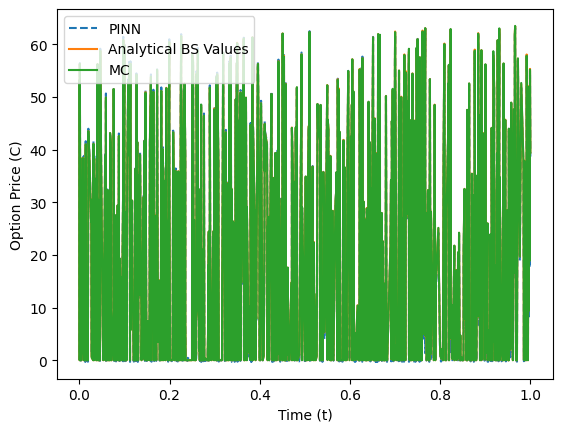

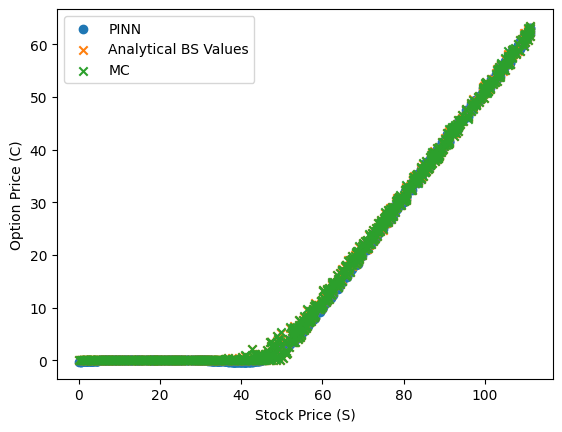

In [ ]:

C = C.reshape(-1)
bs_op_pr = bs_op_pr.reshape(-1)
mc = mc.reshape(-1)


# Sonuçları çizdirme

# Time eksenine göre sıralama
sorted_idx_time = torch.argsort(input_all[:, 2])

t_sorted = input_all[:, 2][sorted_idx_time].detach().cpu().numpy()
C_sorted = C[sorted_idx_time]
bs_op_pr_sorted = bs_op_pr[sorted_idx_time]
mc_sorted = mc[sorted_idx_time]

plt.plot(t_sorted, C_sorted, label="PINN", linestyle='dashed')
plt.plot(t_sorted, bs_op_pr_sorted, label="Analytical BS Values")
plt.plot(t_sorted, mc_sorted, label="MC")
plt.xlabel("Time (t)")
plt.ylabel("Option Price (C)")
plt.legend()
plt.show()

# Scatter plot (S ekseni)
plt.scatter(input_all[:, 0].detach().cpu().numpy(), C, label="PINN", marker='o')
plt.scatter(input_all[:, 0].detach().cpu().numpy(), bs_op_pr, label="Analytical BS Values", marker="x")
plt.scatter(input_all[:, 0].detach().cpu().numpy(), mc, label="MC", marker="x")
plt.xlabel("Stock Price (S)")
plt.ylabel("Option Price (C)")
plt.legend()
plt.show()

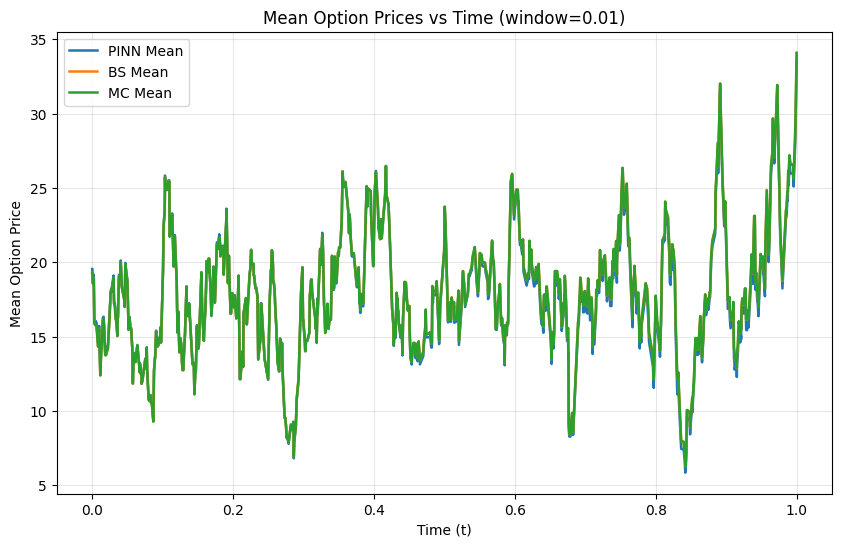

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Zaman boyunca kayarak ortalamaları hesaplayacağımız pencere genişliği
window = 0.01

# Benzersiz t değerlerini almak ve sıralamak (zaten sıralı ama garanti olsun)
unique_t = np.unique(t_sorted)

# Ortalama değerleri tutacak listeler
mean_C = []
mean_bs = []
mean_mc = []
mean_mc = []
t_centers = []

# Her t değeri etrafında ortalama al
for t_center in unique_t:
    idx = np.where( (t_sorted >= t_center - window) & (t_sorted <= t_center + window) )[0]
    if len(idx) > 0:
        mean_C.append(np.mean(C_sorted[idx]))
        mean_bs.append(np.mean(bs_op_pr_sorted[idx]))
        mean_mc.append(np.mean(mc_sorted[idx]))
        t_centers.append(t_center)

# Listeyi numpy array'e çevir
t_centers = np.array(t_centers)
mean_C = np.array(mean_C)
mean_bs = np.array(mean_bs)
mean_mc = np.array(mean_mc)

# Çizim
plt.figure(figsize=(10,6))
plt.plot(t_centers, mean_C, label='PINN Mean', linewidth=1.8)
plt.plot(t_centers, mean_bs, label='BS Mean', linewidth=1.8)
plt.plot(t_centers, mean_mc, label='MC Mean', linewidth=1.8)
plt.xlabel('Time (t)')
plt.ylabel('Mean Option Price')
plt.title(f'Mean Option Prices vs Time (window={window})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


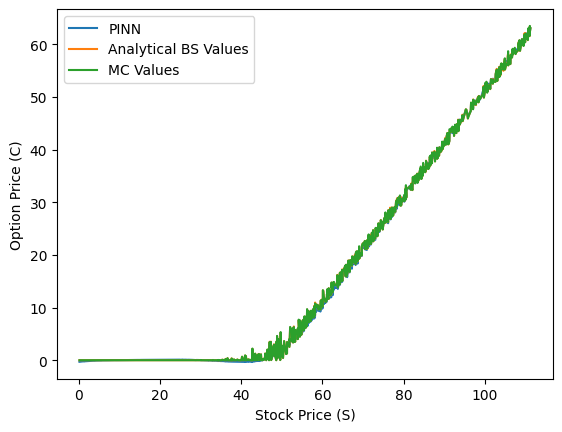

In [ ]:
# Verileri S'ye göre sırala
sorted_indices = np.argsort(input_all[:, 0].detach().cpu().numpy())
S_sorted = input_all[:, 0].detach().cpu().numpy()[sorted_indices]
C_sorted = C[sorted_indices]
bs_sorted = bs_op_pr[sorted_indices]
mc_sorted = mc[sorted_indices]

# Line plot
plt.plot(S_sorted, C_sorted, label="PINN")
plt.plot(S_sorted, bs_sorted, label="Analytical BS Values")
plt.plot(S_sorted, mc_sorted, label="MC Values")

plt.xlabel("Stock Price (S)")
plt.ylabel("Option Price (C)")
plt.legend()
plt.show()



In [ ]:
print(np.sum(C_sorted < 0))

207
